In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from src.Transformer.DecoderOnly import SimplexDecoderOnlyTransformer
from src.Datasets.SyntheticDataset import SimplePeriodicDataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimplePeriodicDataset(len_timeseries=512, seq_len=48, shift=1)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# === Model ===
model = SimplexDecoderOnlyTransformer(
    d_in=dataset[0][0].shape[-1] + dataset[0][1].shape[-1],
    emb_size=64,
    num_layers=2,
    ffn_n_hidden=128
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === Train Loop ===
train_losses, val_losses = [], []
for epoch in range(80):
    model.train()
    running_loss = 0
    for X, fX, _, y in train_loader:
        X, fX, y = X.to(device), fX.to(device), y.to(device)
        mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0).repeat(X.shape[0], 1, 1)

        optimizer.zero_grad()
        out = model(X, fX, mask=mask)
        loss = criterion(out[:, -1], y[:, -1])  # predict last step
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # === Validation ===
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X, fX, _, y in val_loader:
            X, fX, y = X.to(device), fX.to(device), y.to(device)
            mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0).repeat(X.shape[0], 1, 1)
            out = model(X, fX, mask=mask)
            loss = criterion(out[:, -1], y[:, -1])
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

d:\Bestanden\Documenten\GitHub\attention_analysis\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Bestanden\Documenten\GitHub\attention_analysis\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Bestanden\Documenten\GitHub\attention_analysis\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([29, 64])). This will likel

Epoch 01 | Train Loss: 5739.3864 | Val Loss: 5733.3221
Epoch 02 | Train Loss: 5573.9469 | Val Loss: 5359.1978
Epoch 03 | Train Loss: 5021.4498 | Val Loss: 4628.9266
Epoch 04 | Train Loss: 4164.3746 | Val Loss: 3513.5918
Epoch 05 | Train Loss: 2986.4436 | Val Loss: 2215.0182
Epoch 06 | Train Loss: 1862.3864 | Val Loss: 1183.3381
Epoch 07 | Train Loss: 1279.5471 | Val Loss: 749.0846
Epoch 08 | Train Loss: 1162.0003 | Val Loss: 698.0264
Epoch 09 | Train Loss: 1163.0651 | Val Loss: 734.9301
Epoch 10 | Train Loss: 1179.1419 | Val Loss: 713.0941
Epoch 11 | Train Loss: 1162.9503 | Val Loss: 705.5293
Epoch 12 | Train Loss: 1174.6400 | Val Loss: 718.6127
Epoch 13 | Train Loss: 1152.2113 | Val Loss: 693.7852
Epoch 14 | Train Loss: 1128.2366 | Val Loss: 685.6092
Epoch 15 | Train Loss: 1129.0929 | Val Loss: 649.0243
Epoch 16 | Train Loss: 1084.1482 | Val Loss: 587.1586
Epoch 17 | Train Loss: 1097.9422 | Val Loss: 521.5049
Epoch 18 | Train Loss: 1057.8373 | Val Loss: 467.4703
Epoch 19 | Train Loss:

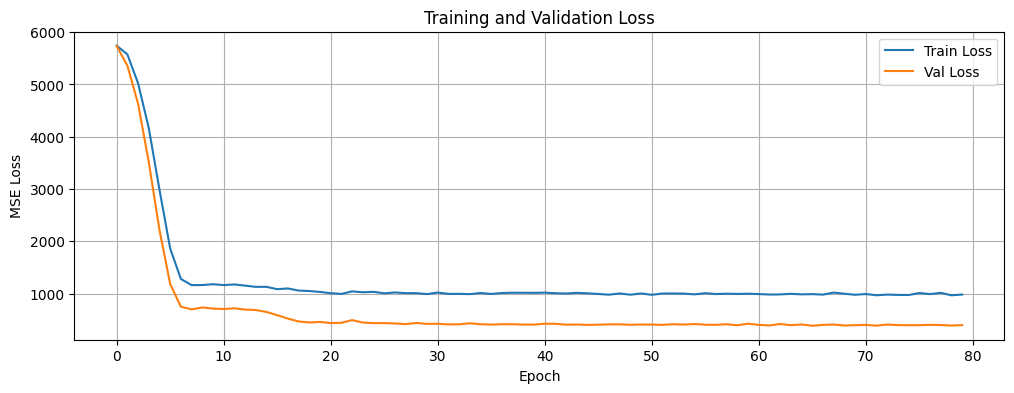

In [4]:
# === Plot Loss ===
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

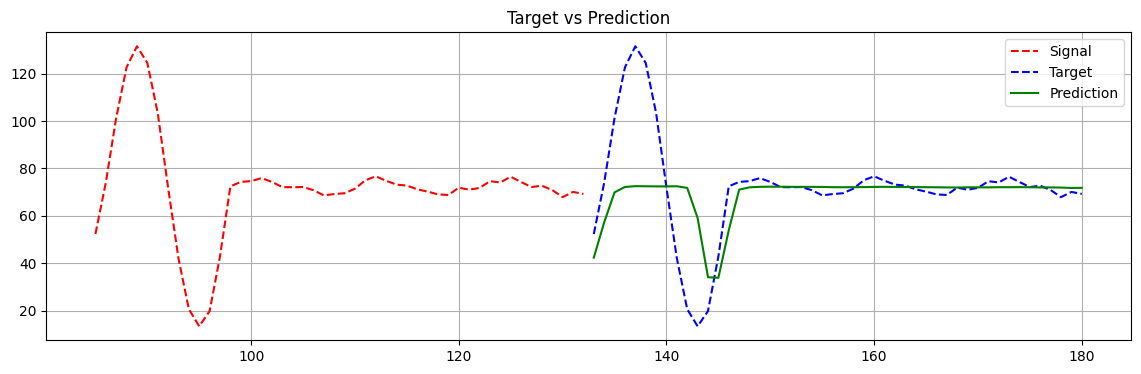

In [5]:
# === Visualize Prediction ===
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Signal')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

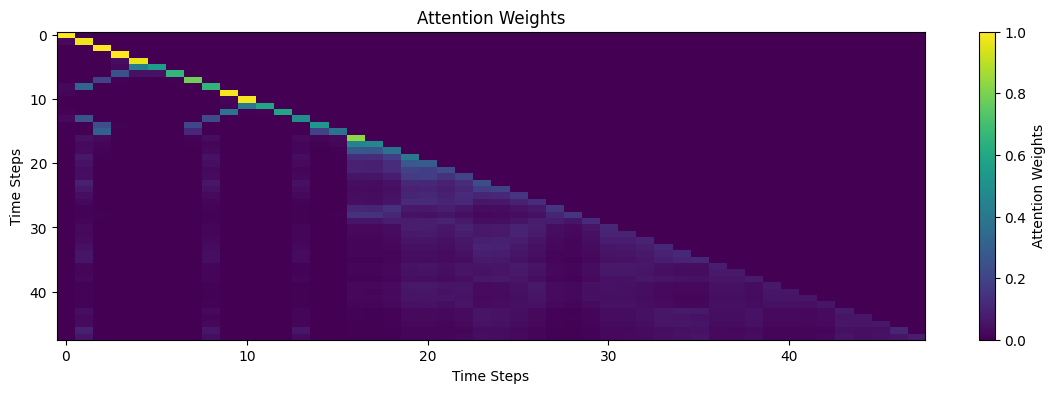

In [10]:
# visualize attention weights in a plot underneath the time series
plt.figure(figsize=(14, 4))
plt.imshow(model.transformer_blocks[0].attention.attention_weight.squeeze(0).cpu(), cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weights')
plt.title("Attention Weights")
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")
plt.show()
